# Using optimal filter from Atick and Redlich, 1990. "Towards a theory of early visual processing."  
  
  Here we simulate the receptive field that minimizes redundancy subject to a total variance restraint, translation invariance, and minimum information requirements.

In [42]:
import numpy as np
#from numpy.fft import fft
import info_theory_functions as info
from scipy.optimize import minimize
from scipy import fft, arange
from scipy.stats import sem
from random import randint
from cmath import polar
from numpy.fft import fft2
from numpy.fft import fftshift
from sklearn.decomposition import PCA
from lnl_model_functions import *


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import functions to compute idealized filter, load images, compute 2d fft

In [19]:
def soln(R_0, inputNoise, outputNoise, lagrangeMultiplier):
    '''R_0 is input covariance matrix
       R is R_0 + N^2 delta_n,m'''
    #R = np.array(R_0) + inputNoise**2 #* np.eye(*R_0.shape)
    return (outputNoise/inputNoise)*np.sqrt([0.5*(r0/(r0+inputNoise**2))*(1 + np.sqrt(1+(2*lagrangeMultiplier*inputNoise**2)/r0))-1 for r0 in R_0])

In [20]:
def getLambda(r0, inputNoise, outputNoise):
    
    N = inputNoise
    def lhs(lam):
        #return np.sum(np.log([np.sqrt(r/(2*lam*inputNoise**2))+np.sqrt(1+(r/2*lam*inputNoise**2)) for r in R_0]))
        return np.sum(np.log(np.sqrt(r0/(2 * lam * N**2)) + np.sqrt(1 + (r0/(2 * lam * N**2)))))
    
    #R = np.array(R_0) + inputNoise**2
    r0 = np.array(r0)
    r  = r0 + N**2
    #rhs = 0.5*np.sum(np.log([(r*(inputNoise**2 + outputNoise**2))/(inputNoise**2 * (r + outputNoise**2)) for r in R]))
    rhs = 0.5 * np.sum(np.log((r/(N**2)) * ((N**2 + outputNoise**2)/(r + outputNoise**2))))
    
    def relativeDifference(lam):
        left = lhs(lam)
        return abs(left-rhs)/(abs(left) + abs(rhs))
    
    lam = 5*rand(1)
    res = minimize(relativeDifference, x0=lam, method='nelder-mead')
    
    return res.x, res.fun

In [21]:
def uniqueSoln(r0, inputNoise, outputNoise, verbose=True):
    '''R_0 is input covariance matrix
       R is R_0 + N^2 delta_n,m'''
    #R = np.array(R_0) + inputNoise**2 #* np.eye(*R_0.shape)
    
    #import pdb
    #pdb.set_trace()
    
    N  = inputNoise
    r0 = np.array(r0)
    r  = r0 + N**2
    
    lam, relErr = getLambda(r0, inputNoise, outputNoise)
    if verbose:
        print 'The relative error from this choice of Lagrangian multiplier is %s.' %(relErr)
        
    #import pdb
    #pdb.set_trace()
    
    f = ((1. / N**2) * (.5 * r0/r * (1 + np.sqrt(1 + (2 * lam * N**2)/r0)) - 1)).astype(complex)
    
    return real(outputNoise * np.sqrt(f))

In [22]:
def oneGaussian(x, original):
    sigma1,sigma2,strength1,strength2 = x
    xs = linspace(-5,5,len(original))
    ourGaussian = abs(strength1)*gaussian(x=xs, sigma=abs(sigma1)) - abs(strength2)*gaussian(x=xs, sigma=abs(sigma2))
    return ourGaussian

In [23]:
def oneGaussiansError(x,original):
    ourGaussian = oneGaussian(x, original)
    return sum(abs(ourGaussian-original))

In [24]:
def fitGaussians(strength1,strength2,sigma1,sigma2):
    original=filt
    #sigma1,sigma2,strength1,strength2 = x
    xs = linspace(-5,5,len(original))
    ourGaussian = abs(strength1)*gaussian(x=xs, sigma=abs(sigma1)) - abs(strength2)*gaussian(x=xs, sigma=abs(sigma2))
    
    #print sum(abs(ourGaussian-original)) #oneGaussiansError([strength1,strength2,sigma1,sigma2],original)
    print oneGaussiansError([sigma1, sigma2, strength1, strength2], original)

    plot(original,'k',linewidth=3)
    plot(ourGaussian,'r',linewidth=2,alpha=0.8)
    
    return ourGaussian
    

In [25]:
def load_images(path, numImages, patchSize=None, acceptedExtensions=['.imc','LUM.mat'], square=False, normalize='subtract'):
    from os import listdir
    from os.path import isfile, join
    import array as ar
    import scipy.io
    
    allfiles = []
    for ext in acceptedExtensions:
        allfiles = allfiles + [f for f in listdir(path) if isfile(join(path,f)) and ext in f]
    if len(allfiles) < numImages:
        print 'Only ' + str(len(allfiles)) + ' files in directory.'
    names    = allfiles[:numImages]
    patches  = []

    for im in names:
        if '.imc' in im:
            fin = open(path+'/'+im, 'rb')
            s   = fin.read()
            fin.close()
            arr = ar.array('H', s)
            arr.byteswap()
            img = np.array(arr, dtype='uint16').reshape(1024,1536)
        elif '.mat' in im:
            fin = scipy.io.loadmat(path+'/'+im)
            arr = fin['LUM_Image']
            # make 0 to 255
            arr = arr - min(arr.flat)
            arr = 255.*arr/max(arr.flat)
            img = np.array(arr, dtype='uint16')
            
        # make patches
        if patchSize:
            img_center = [np.shape(img)[0]/2,np.shape(img)[1]/2]
            img        = img[img_center[0]-patchSize/2:img_center[0]+patchSize/2,img_center[1]-patchSize/2:img_center[1]+patchSize/2]
            
        if square:
            N = min(shape(img))
            N = N - (N % 2) # make even
            img = img[:N,:N]
        
        if normalize == 'subtract':
            # normalize to unit variance and zero mean (originally I did these in opposite order, but this
            # is the official z-scoring order I believe)
            img -= np.mean(img)
            patches.append(img/np.std(img))
        elif normalize == 'divisive':
            # normalize by the mean
            patches.append(img/np.mean(img))
        else:
            patches.append(img)

    return patches

In [26]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (phi, rho)

In [27]:
def rotavg(im):
    '''im can be square 2d numpy array'''
    imShape = shape(im) # NNM
    N       = imShape[0]
    X, Y    = np.meshgrid(range(-N//2,N//2),range(-N//2,N//2))

    theta, rho = cart2pol(X,Y);
    rho = rho.round()
    f   = [mean(im[np.where(rho==r)]) for r in range(N//2+1)] 
        
    return f

In [29]:
def spectrum2d(arr, Fs=1000.0, frequencyFlag=True):
    amp = abs(fftshift(fft2(arr)))/np.prod(arr.shape)
    amp = rotavg(amp)
    n = len(amp)
    #amp = amp/n
    k = arange(n)
    T = n/Fs
    frq = k/(2*T) # two sides frequency range
    #frq = frq[range(n/2)] # one side frequency range
    
    if frequencyFlag:
        #return (frq, [a/n**2 for a in amp])  # should n be squared?
        return (frq, amp)
    else:
        #return [a/n**2 for a in amp]  # should n be squared?
        return amp

# Import amplitude spectrum from natural images

### Load original images

In [12]:
im_path = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd13A' # flood plain, water, horizon
#im_path = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd01A' # baboons, trees, bushes

In [13]:
ls -1 $im_path | wc -l

     156


In [14]:
numImages = 100
patchSize = None
pixelsToDeg = 92./2
normalize = 'divisive'
averageGanglionSize = 1.5*pixelsToDeg+1 # in pixels

In [15]:
patches = load_images(im_path, numImages, patchSize, square=True, normalize=normalize)

Only 78 files in directory.


### Sample image in degrees

In [30]:
degAxes = [i/pixelsToDeg for i in xrange(patches[0].shape[0])]

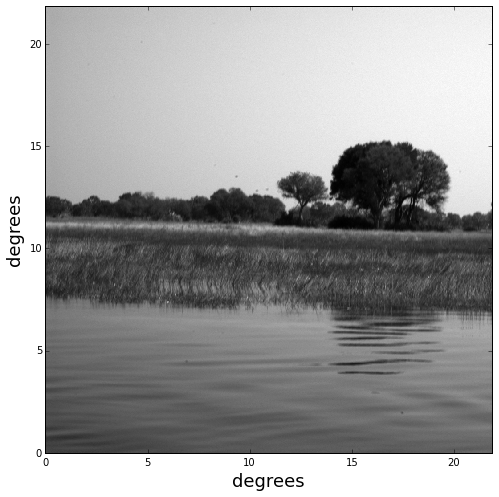

In [31]:
imshow(patches[13], extent=[np.min(degAxes), np.max(degAxes), np.min(degAxes), np.max(degAxes)])
xlabel('degrees',fontsize=18)
ylabel('degrees',fontsize=18)
savefig('example_natural_image.jpg')

## log 2d FFT plot of this sample image

#### Highest frequency is then 1/degree_spacing

In [32]:
samplingRate = pixelsToDeg    # Fs
spacing      = 1./pixelsToDeg # T
highest_freq = 1./(2*spacing)

print 'The sampling rate is %s pixels per degree.' %(samplingRate)
print 'The images are sampled at %f degree spacing.' %(spacing)
print 'Highest frequency should be %s 1/deg.' %(highest_freq)

The sampling rate is 46.0 pixels per degree.
The images are sampled at 0.021739 degree spacing.
Highest frequency should be 23.0 1/deg.


In [33]:
amp = abs(fftshift(fft2(patches[0])))
rot = rotavg(amp)
print (shape(amp), shape(rot))

((1006, 1006), (504,))


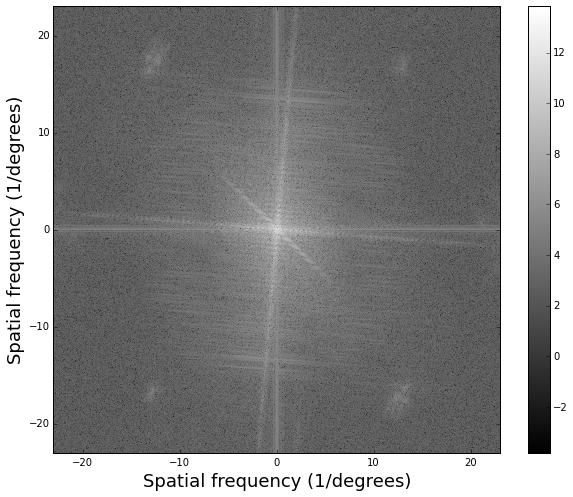

In [34]:
imshow(log(amp), extent=[-highest_freq, highest_freq, -highest_freq, highest_freq])
colorbar()
ylabel('Spatial frequency (1/degrees)',fontsize=18)
xlabel('Spatial frequency (1/degrees)',fontsize=18)

### Compute rotationally averaged amplitude spectrum

In [38]:
allRot  = [spectrum2d(p,Fs=pixelsToDeg,frequencyFlag=False) for p in patches]
specRot = mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],Fs=pixelsToDeg,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors = error
originalFreqs = frqRot

In [39]:
print 'Maximum frequency is %f, should be %f' %(np.max(originalFreqs), highest_freq)

Maximum frequency is 22.954365, should be 23.000000


In [40]:
print 'Minimum frequency is %f, should be %f' %(originalFreqs[1], 1./np.max(degAxes))

Minimum frequency is 0.045635, should be 0.045771


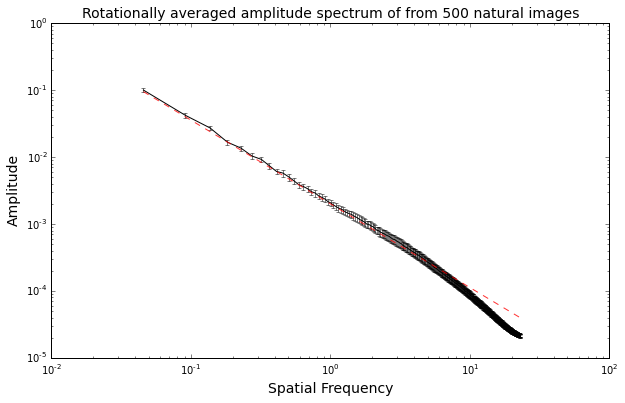

In [43]:
fig,ax = subplots()
fig.set_size_inches((10,6))

ax.errorbar(originalFreqs[1:], originalSpectra[1:], yerr=originalErrors[1:], fmt='none', ecolor='k', capsize=2, capthick=1, alpha=0.5)
ax.plot(originalFreqs[1:], originalSpectra[1:], color='k', alpha=0.99)
# ax.plot(originalFreqs, [1.3/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
# ax.plot(originalFreqs, [0.02/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
ax.plot(originalFreqs[1:], [0.002/f**1.25 for f in originalFreqs[1:]], color='r', linestyle='--', alpha=0.8)

ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')

ax.set_title('Rotationally averaged amplitude spectrum of from 500 natural images', fontsize=14)
ax.set_xlabel('Spatial Frequency', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)

#ylim([10e-7,10e-1])
# ylim([10e-4,10e1])
#ylim([10e-5,1])
#savefig('Figures/00 Average power spectrum of original images.png')

In [44]:
print 'Actual DC component is %s, should be %f. E.g., the mean of the first patch is %s' %(originalSpectra[0], np.mean(patches), abs(fft2(patches[0])[0,0]/np.prod(patches[0].shape)))

Actual DC component is 1.0, should be 1.000000. E.g., the mean of the first patch is 1.0


# Original Atick & Redlich paper use the Fourier transform of the covariance matrix, which is equivalent to $F[x]^2$

In [46]:
powerSpectra = originalSpectra**2

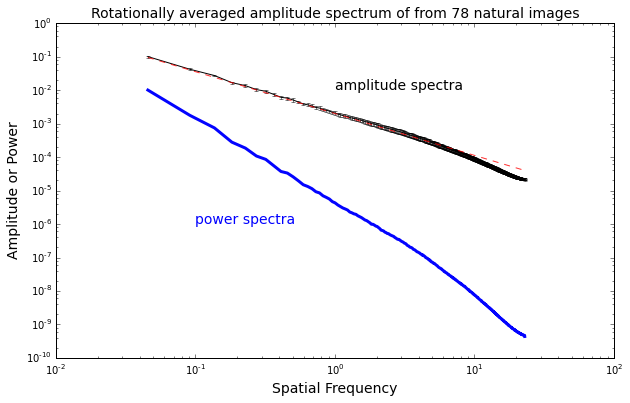

In [62]:
fig,ax = subplots()
fig.set_size_inches((10,6))

ax.errorbar(originalFreqs[1:], originalSpectra[1:], yerr=originalErrors[1:], fmt='none', ecolor='k', capsize=2, capthick=1, alpha=0.5)
ax.plot(originalFreqs[1:], originalSpectra[1:], color='k', alpha=0.99)
# ax.plot(originalFreqs, [1.3/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
# ax.plot(originalFreqs, [0.02/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
ax.plot(originalFreqs[1:], [0.002/f**1.25 for f in originalFreqs[1:]], color='r', linestyle='--', alpha=0.8)

ax.plot(originalFreqs[1:], powerSpectra[1:], color='b', alpha=0.99, linewidth=3)

ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')

ax.set_title('Rotationally averaged amplitude spectrum of from 78 natural images', fontsize=14)
ax.set_xlabel('Spatial Frequency', fontsize=14)
ax.set_ylabel('Amplitude or Power', fontsize=14)

ax.annotate('amplitude spectra', (10e-1, 10e-3), fontsize=14, color='k')
ax.annotate('power spectra', (10e-2, 10e-7), fontsize=14, color='b')

#ylim([10e-7,10e-1])
# ylim([10e-4,10e1])
#ylim([10e-5,1])
savefig('Figures/00 Average amplitude and power spectra of original images.png')